In [1]:
import psycopg2
from psycopg2.extensions import register_adapter, AsIs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import collections
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.cluster import KMeans
import string
import wfdb

np.set_printoptions(suppress=True,precision=10)

In [24]:
def obtainMeasures(dbname="mimic",unlimit=False,centroid=None) :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    limit = "" if unlimit else " LIMIT 10000 "
    null = " AND centroid is null" if centroid is None else "AND centroid IS NOT NULL" if centroid =="notNull" else "" 
    select_stament = ("SELECT DISTINCT qt,ts,sr,centroid FROM rstq "
                      " WHERE qt IS NOT NULL "
                      " AND qt > 0 AND qt<1000 "
                      " AND ts > 0 "
                      " AND ts IS NOT NULL "
                      " AND sr IS NOT NULL "+null+limit)
    cur.execute(select_stament)
    waves = []
    for row in cur :
        qt = row[0]
        ts = row[1]
        sr = row[2]
        if centroid  =="notNull" :
            waves.append([qt,ts,sr,row[3]])
        else :
            waves.append([qt,ts,sr])
    conn.close()
    return waves

In [3]:
def printKmeans(kmeans) :
    labels, values = zip(*collections.Counter(kmeans.labels_).items())
    indexes = np.arange(len(labels))
    width = 0.5
    fig, ax = plt.subplots() 
    for i, v in enumerate(values):
        ax.text(i-0.1,v+1, str(v), color='blue', fontweight='bold')
    plt.bar(indexes, values, width)
    plt.title('Cantidad de Latidos por centroide')
    plt.ylabel('Cantidad de latidos')
    plt.xlabel('Centroides')
    plt.xticks(indexes + width * 0.01, labels)
    plt.show()

In [4]:
waves = obtainMeasures(centroid="all",unlimit=True)
X = np.array(waves)

### Let's find an possible Elbow in the k-means to choise the value of k

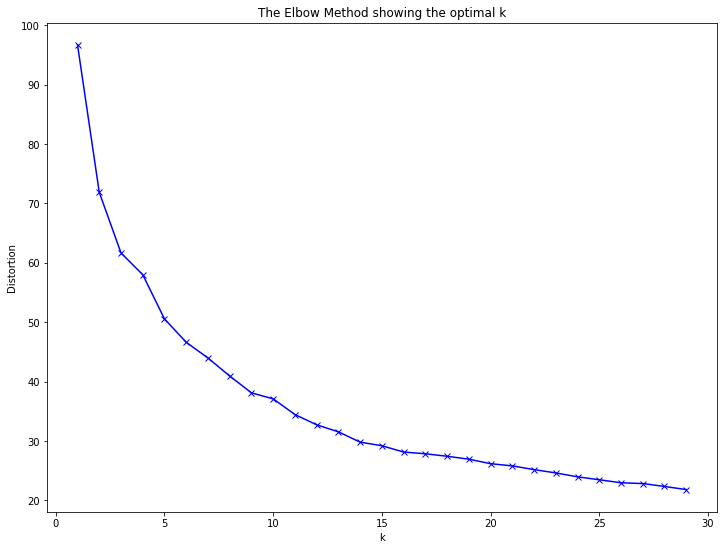

In [50]:
# k means determine k
distortions = []
K = range(1,60)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [63]:
for i in range(1,len(distortions)) :
    print(str(i)+":",distortions[i-1]-distortions[i],end=", ")

1: 24.8289521924, 2: 10.2057017901, 3: 3.66308997958, 4: 7.44387611444, 5: 3.93045961079, 6: 2.64691657843, 7: 3.03612485787, 8: 2.83073046993, 9: 1.01617466903, 10: 2.63672638937, 11: 1.72929574875, 12: 1.18185093518, 13: 1.7389334229, 14: 0.603430278952, 15: 1.06388350938, 16: 0.288222498969, 17: 0.41875633021, 18: 0.490694616483, 19: 0.760109518452, 20: 0.36925772515, 21: 0.630480446948, 22: 0.553333681241, 23: 0.659628534812, 24: 0.49035178812, 25: 0.508775901741, 26: 0.128926448706, 27: 0.493486954018, 28: 0.520937674611, 

### Not clear elbow found, but how im interested more to find a value where the distortion is low, all over 16 gives a distorsion lower that 1%, so lets stay with that

In [12]:
centroid=np.array([
    [50.5071305823,24.881919841,23.2529951703]
    ,[20.2473360804,62.1582901186,20.4052887689]
    ,[98.499587538,20.6075282791,16.276733753]
,[75.1205203381,65.9683612764,15.1328740998]
,[153.6149123804,31.7576859987,13.3017231579]
,[35.4864510588,31.8080547834,75.1738648948]
,[31.1250815851,128.983030303,46.8134498835]
,[225.9710812505,30.3225489929,13.0517321268]
,[314.2643021938,30.7959566731,14.3275329449]
,[432.430518878,29.8037256441,14.6478481193]
,[30.7382086708,80.8698189614,253.5559790376]
    ,[596.1409656279,28.4421559449,14.5276180286]
    ,[28.319121447,264.886627907,59.7496770026]
    ,[818.1602238047,28.6286876907,13.2232960326]
,[28.5194109772,99.5037929496,581.2423025435]
,[25.0153774464,535.7129543336,134.0475302889]])
kmeans = KMeans(n_clusters=16
                ,init=centroid,n_init=1
               ).fit(X)

In [13]:
centroid = kmeans.cluster_centers_
print(centroid)

[[  47.8142075849   25.2144034199   26.6818876576]
 [  19.9833877496   63.7120151495   22.6541595925]
 [  97.8970079586   19.3932469189   18.4668894187]
 [  77.1290156365   68.6064131275   16.2567232803]
 [ 154.4780385975   33.4951433562   14.4733310612]
 [  35.7632929235   32.6251198196   81.2345644206]
 [  30.9094690666  131.3345434378   48.3440477991]
 [ 227.8375406895   31.8118647446   14.2138444164]
 [ 317.0779587009   31.9385518057   15.4214500136]
 [ 434.933937925    30.4620436244   15.0911578454]
 [  30.5525353486   81.5581423696  255.880058508 ]
 [ 597.0349514562   28.7515950069   14.7772538141]
 [  28.2843020283  269.3666268962   59.7833645816]
 [ 818.4902313624   28.7694087404   13.2917737789]
 [  28.5426774483   99.1482479784  582.3647798742]
 [  25.0009438414  537.3945257197  134.617744219 ]]


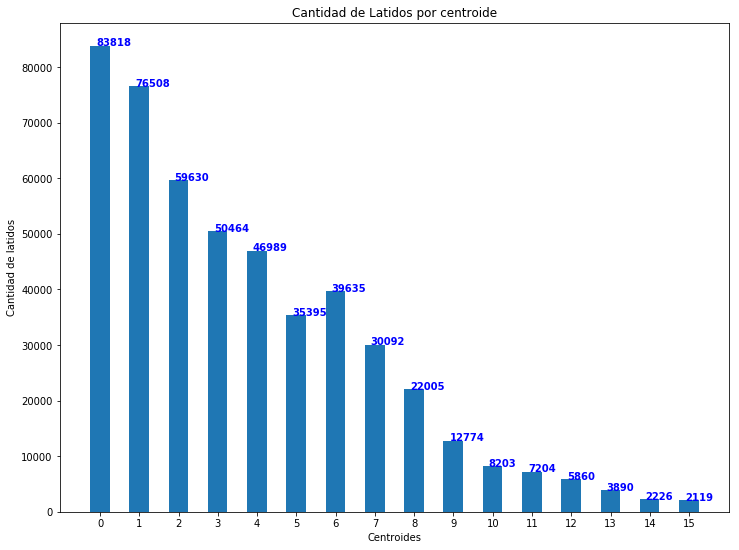

In [14]:
printKmeans(kmeans)

In [9]:
def updateQRST(wacentroid) :
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    select_stament = """
    UPDATE rstq AS t
    SET
        centroid = s.centroid
        FROM unnest(%s) s(qt integer,ts integer,sr integer,centroid unknown)
        WHERE t.qt = s.qt
        AND t.ts = s.ts
        AND t.sr = s.sr;
    """
#    print(cur.mogrify(select_stament, (wacentroid,)))
    cur.execute(select_stament, (wacentroid,))
    conn.commit()
    conn.close()

In [8]:
def fillEmptyCentroids(waves, iterations=1280) :
    print("measures obtained:"+str(len(waves)))
    waves = waves[:iterations] if iterations<len(waves) else waves
    numberToAlpha = dict(enumerate(string.ascii_lowercase, 0))
    i = 1
    centro = []
    for wave in waves :
        try:
            centValue = numberToAlpha[kmeans.predict([[wave[0],wave[1],wave[2]]])[0]]
            centro.append((wave[0],wave[1],wave[2],str(centValue)))
        except:
            print("error in value")
        i=i+1
    if centro != [] :
        updateQRST(centro)

In [9]:
waves = obtainMeasures(unlimit=True,centroid=None)
fillEmptyCentroids(waves,iterations=10)

measures obtained:0


In [20]:
fig_size = [12,9]
plt.rcParams["figure.figsize"] = fig_size
def centroidColor(clist) :
    color = {
        'a': "blue",
        'b': "red",
        'c': "green",
        'd': "magenta",
        'e': "cyan",
        'f': "fuchsia",
        'g': "limegreen", 
        'h': "pink",
        'i': "yellow",
        'j': "aqua",
        'k': "peru",
        'l': "lawngreen",
        'm': "maroon",
        'n': "navajowhite",
        'o': "orange",
        'p': "coral",
        None : "maroon"
    }
    return [color[x] for x in clist]

In [21]:
waves = obtainMeasures(unlimit=True,centroid="notNull")
qt = np.array([-item[0] for item in waves])
ts = np.array([item[1] for item in waves])
sr = np.array([item[2] for item in waves])
color = np.array([item[3] for item in waves])
qtc = np.array([-int(item[0]) for item in centroid])
tsc = np.array([item[1] for item in centroid])
src = np.array([item[2] for item in centroid])
color = centroidColor(color)

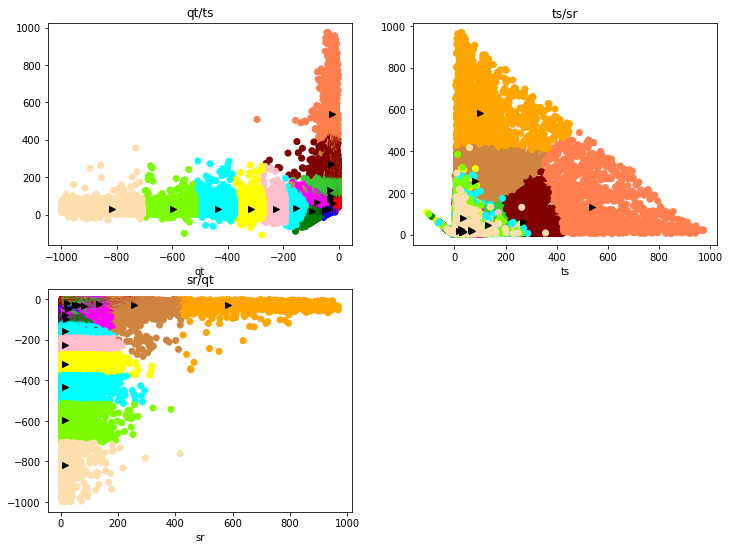

In [22]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.set_title("qt/ts")
ax.set_xlabel("qt")
ax.scatter(qt,ts, c=color)
ax.scatter(qtc,tsc,c='black', marker=">")
ax = fig.add_subplot(222)
ax.set_title("ts/sr")
ax.set_xlabel("ts")
ax.scatter(ts,sr, c=color)
ax.scatter(tsc,src,c='black', marker=">")
ax = fig.add_subplot(223)
ax.set_title("sr/qt")
ax.set_xlabel("sr")
ax.scatter(sr,qt, c=color)
ax.scatter(src,qtc,c='black', marker=">")
plt.show()

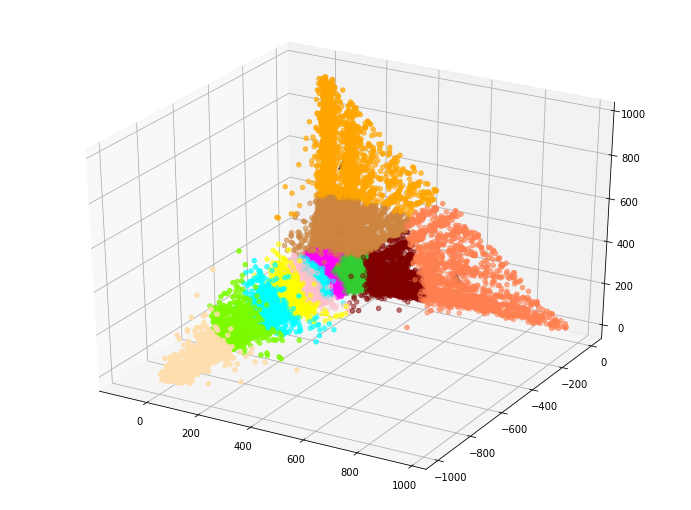

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ts,qt, sr, c=color)
ax.scatter(tsc,qtc, src, c='black',marker="^",s=160)
plt.show()

In [29]:
def findCentroid(centroid,window=0,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    qt = str(centroid[0])
    ts = str(centroid[1])
    sr = str(centroid[2])
    strWin = str(window)
    select_stament = ("SELECT rstq.record,r_s,q_s,a.rec_from,a.rec_to,wave,centroid "
                      " FROM rstq LEFT JOIN a ON a.record=rstq.record  "
                      " WHERE "
                      " (qt between floor("+qt+")-"+strWin+" and ceil("+qt+")+"+strWin+")"
                      " AND (ts between floor("+ts+")-"+strWin+" and ceil("+ts+")+"+strWin+")"
                      " AND (sr between floor("+sr+")-"+strWin+" and ceil("+sr+")+"+strWin+")"
                      " AND rstq.record not in ('mimic2wdb/matched/s23890/s23890-2832-10-25-12-55',"
                      " 'mimic2wdb/matched/s20486/s20486-2701-07-11-18-41') "
                      " AND rstq.record not like 'mimic3wdb%' "
                      " LIMIT 1")
    cur.execute(select_stament)
    notFound = True
    for row in cur :
        notFound = False
        pbdir = row[0]
        wave = pbdir.split("/")[3]
        pbdir = pbdir.replace("/"+wave,'')
        return {"pbdir":pbdir,"onda":wave,"r_s":row[1],"q_s":row[2],"rec_from":row[3],"rec_to":row[4],"wave":row[5],"centroid":row[6]}
    if(notFound) :
        return findCentroid(value,window=window+1)

In [30]:
def updateOriginalWave(wave,originalWave):
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    select_stament = ("UPDATE rstq SET wave = (%s) "
                      "WHERE record = (%s) AND r_s = (%s) AND q_s = (%s)")
    record=wave['pbdir']+"/"+wave['onda']
    print(record+"r_s"+str(wave['r_s']))
    cur.execute(select_stament, (originalWave.tolist(),record,wave['r_s'],wave['q_s'],))
    conn.commit()
    cur.close()
    conn.close()

In [31]:
def printCentroid(wave) :
    onda = wave['onda']
    originalWave = wave['wave']
    if originalWave is None :
        sig, fields = wfdb.srdsamp(onda,pbdir=wave['pbdir'], sampto=1)
        signalII = fields['signame'].index("II")
        sfrom = wave['rec_from']+wave['r_s']-20
        sto   = wave['rec_from']+wave['q_s']
        #sto = sfrom+100 if sto-sfrom>100 else sto
        originalWave = wfdb.rdsamp(onda,pbdir=wave['pbdir'],channels =[signalII], sampfrom=sfrom, sampto=sto).p_signals
        originalWave = originalWave[~np.isnan(originalWave)]
        updateOriginalWave(wave,originalWave)
    ax.set_title(wave['centroid'])
    ax.plot(originalWave[:100])

In [ ]:
fig = plt.figure()
inx= 1
for value in centroid :
    ax = fig.add_subplot(4,4,inx)
    wave = findCentroid(value)
#    print("wave",wave)
    printCentroid(wave)
    inx=inx+1
plt.show()

mimic2wdb/matched/s04742/s04742-2934-11-15-15-32r_s48487
